In [2]:
import pickle
import numpy as np
from tqdm import tqdm
from skimage.color import gray2rgb
from NOMADS_postproc import postproc
from matplotlib import pyplot as plt
from Quality import compute_overlap_array, evaluate, make_overlap_img

# Import Algorithm and Data Handler (from rapidalg)

In [18]:
from NOMADS_beta import NomadsBeta
from data_handler import load_and_preproc, get_train_set

## Load And Preprocess Data
- Z-Transform within slice

In [4]:
data = load_and_preproc('./data/rorb_data.data', True)

## Make Train Set
- Method get_train_set included in Data Handler
    - Any Shape Volume
    - Any Num Channels
    - Any Class Balance Ratio

In [5]:
biomarker_list = ['PSD95', 'synapsin', 'Gephyrin', 'VGlut1', 'GABA', 'GAD2', 'GluN1']
features, labels = get_train_set(data, 8, biomarker_list, balance=True, positive_to_negative_ratio=.5)

train_features = features[:int(.8*len(features))]
train_labels = labels[:int(.8*len(features))]

test_features = features[int(.8*len(features)):]
test_labels = labels[int(.8*len(features)):]

## Make NomadsBeta Model & Run Training

In [6]:
model = NomadsBeta(len(biomarker_list),
                   learning_rate = 1e-4,
                   decay=0.005)

<IPython.core.display.Javascript object>


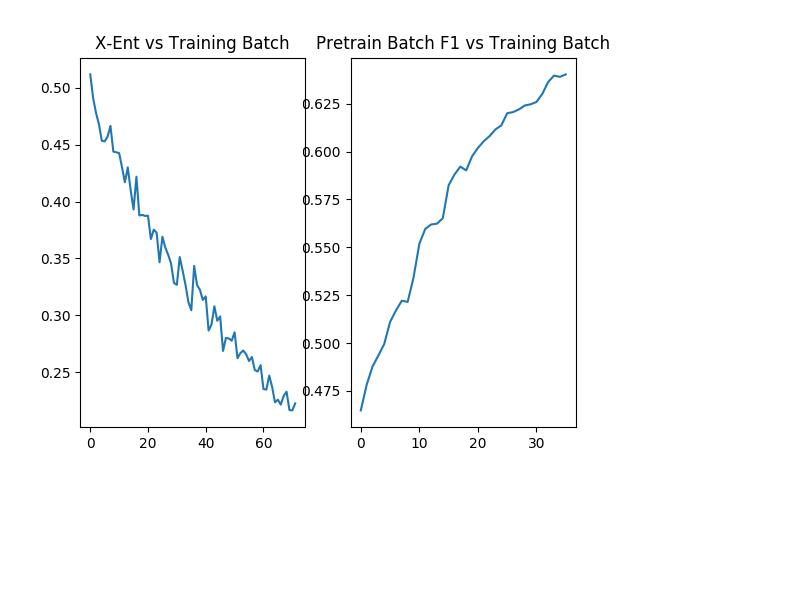

KeyboardInterrupt: 

In [19]:
%matplotlib notebook

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('X-Ent vs Training Batch')
ax2 = fig.add_subplot(122)
ax2.set_title('Pretrain Batch F1 vs Training Batch')
plt.ion()
fig.show()
fig.canvas.draw()

batch_size = 2048
losses = []
f1s = []

#50 Iterations for sake of Demo
for idx, batch_start_idx in enumerate(range(50)):
    batch_features = np.stack(train_features[batch_start_idx:batch_start_idx+batch_size])
    batch_labels = np.stack(train_labels[batch_start_idx:batch_start_idx+batch_size])
    if not idx % 2:
        batch_pretrain_pred = model.predict_on_batch(batch_features)
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(batch_labels)):
            if np.argmax(batch_pretrain_pred[i]) == np.argmax(batch_labels[i]):
                if np.argmax(batch_labels[i]):
                    tp +=1
            else:
                if np.argmax(batch_labels[i]):
                    fn +=1
                else:
                    fp +=1

        prec = tp/(tp+fp+1)
        rec = tp/(tp+fn+1)
        f1 = 2*prec*rec/(prec+rec+1)
        f1s.append(f1)

        ax2.clear()
        ax2.plot(f1s)
        ax2.set_title('Pretrain Batch F1 vs Training Batch')
        fig.canvas.draw()

    cur_loss = model.train_on_batch(batch_features, batch_labels)
    losses.append(cur_loss)
    

    ax1.clear()
    ax1.plot(losses)
    ax1.set_title('X-Ent vs Training Batch')
    fig.canvas.draw()

    
    if not idx % 100:
        model.checkpoint('./data/nomads_model_' + str(idx) + '_minibatches.h5')
        
        

# Models can be Saved & Loaded
- NomadsBeta.checkpoint
- Initializer takes path to checkpoint file

In [20]:
loaded_model = NomadsBeta(len(biomarker_list),
                          learning_rate = 1e-4,
                          decay=.0005,
                          checkpoint='./data/nomads_model_300_minibatches.h5')

# Evaluate on Test Set

In [21]:
test_set_predictions = loaded_model.predict_on_batch(np.stack(test_features))

In [22]:
tp = 0
fp = 0
fn = 0
for i in range(len(test_set_predictions)):
    if np.argmax(test_set_predictions[i]) == np.argmax(test_labels[i]):
        if np.argmax(test_labels[i]):
            tp +=1
    else:
        if np.argmax(test_labels[i]):
            fn +=1
        else:
            fp +=1

In [23]:
prec = tp/(tp+fp)
rec = tp/(tp+fn)
print('Prec: ', prec)
print('Rec: ', rec)
print('F1: ', 2*prec*rec/(prec+rec))

Prec:  0.6908003985386915
Rec:  0.4977267288825078
F1:  0.5785813630041725


In [12]:
vis_stack = []
vis_slice=15
for key in biomarker_list: 
    vis_stack.append(data[key][vis_slice])
vis_stack = np.stack(vis_stack)
vis_stack = np.moveaxis(vis_stack, 0, -1)

In [13]:
vis_predictions = np.zeros(vis_stack.shape[:-1])
radius = 8
for y in tqdm(range(radius, vis_stack.shape[0] -radius - 1)):
    for x in range(radius, vis_stack.shape[1] - radius - 1):
        window = vis_stack[y-radius:y+radius, x-radius:x+radius]
        prediction = np.squeeze(loaded_model.predict_on_batch(np.stack([window])))
        if np.argmax(prediction):
            vis_predictions[y, x] = 1
            

100%|██████████| 119/119 [00:19<00:00,  6.02it/s]


# Postprocessing
- Remove small things

In [14]:
postproc_predictions = postproc(vis_predictions, 10)

# Look at It!

<IPython.core.display.Javascript object>


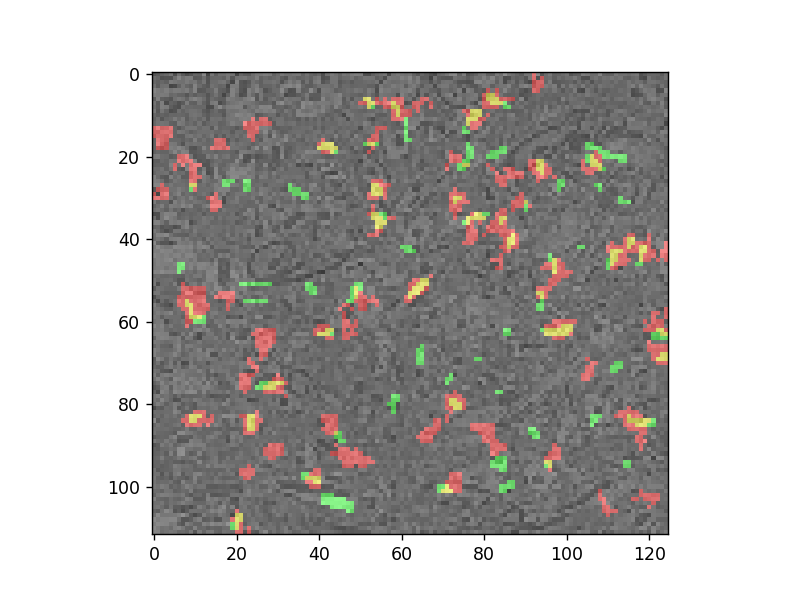

In [17]:
gt = data['annotation'][vis_slice]
test_em = pickle.load(open('./data/rorb_em.beta2_data', 'rb'))

plt.figure()
plt.imshow(make_overlap_img(postproc_predictions,  gt)[radius:-radius, radius:-radius], alpha=.65)
plt.imshow(test_em['em_clahe'][0][:-20, :], cmap='gray', alpha=.35)
plt.show()